<a href="https://colab.research.google.com/github/danieladoghe/AI-projects-/blob/main/Stock_Market_Prediction_using_GAN_(TLSA)_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [200]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.metrics import accuracy_score, precision_score, recall_score
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout,Permute, Flatten, Input, Multiply, Permute, Attention, Concatenate, Dropout, LayerNormalization, Input
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model # Import plot_model from the correct module
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import Model # Import the Model class



import warnings
warnings.filterwarnings("ignore")

In [201]:
stock_name = 'TSLA'

In [202]:
import pandas as pd

try:
    all_tweets = pd.read_csv('/content/stock_tweets 3.csv')
except pd.errors.ParserError as e:
    print(f"Error reading CSV: {e}")
    # Get the line number from the error message
    error_line = int(str(e).split('row ')[-1])

    # Read a few lines before and after the error line
    with open('/content/stock_tweets 3.csv', 'r') as f:
        lines = f.readlines()
        for i in range(error_line - 5, error_line + 5):
            if 0 <= i < len(lines):
                print(f"Line {i+1}: {lines[i]}")

In [203]:
print(all_tweets.shape)
all_tweets.head()

(80793, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [204]:
df = all_tweets[all_tweets['Stock Name'] == stock_name]
print(df.shape)
df.head()

(37422, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [205]:
sent_df = df.copy()
sent_df["sentiment_score"] = ''
sent_df["Negative"] = ''
sent_df["Neutral"] = ''
sent_df["Positive"] = ''
sent_df.head()

,Date,Tweet,Stock Name,Company Name,sentiment_score,Negative,Neutral,Positive
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",,,,
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",,,,
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",,,,
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",,,,
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",,,,


In [206]:
!pip install nltk
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [207]:
%%time
sentiment_analyzer = SentimentIntensityAnalyzer()
for indx, row in sent_df.iterrows():
    try:
        sentence_i = unicodedata.normalize('NFKD', sent_df.loc[indx, 'Tweet'])
        sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
        sent_df.at[indx, 'sentiment_score'] = sentence_sentiment['compound']
        sent_df.at[indx, 'Negative'] = sentence_sentiment['neg']
        sent_df.at[indx, 'Neutral'] = sentence_sentiment['neu']
        sent_df.at[indx, 'Positive'] = sentence_sentiment['pos']
    except TypeError:
        print (sent_df.loc[indexx, 'Tweet'])
        print (indx)
        break

CPU times: user 31.8 s, sys: 99.8 ms, total: 31.9 s
Wall time: 44.8 s


In [208]:
sent_df.head(10)

,Date,Tweet,Stock Name,Company Name,sentiment_score,Negative,Neutral,Positive
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",0.0772,0.127,0.758,0.115
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",0.0,0.0,1.0,0.0
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",0.296,0.0,0.951,0.049
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",-0.7568,0.273,0.59,0.137
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",-0.875,0.526,0.474,0.0
5,2022-09-29 22:25:53+00:00,@RealDanODowd @Tesla This is you https://t.co/...,TSLA,"Tesla, Inc.",0.0,0.0,1.0,0.0
6,2022-09-29 22:24:22+00:00,For years @WholeMarsBlog viciously silenced @T...,TSLA,"Tesla, Inc.",-0.9359,0.329,0.626,0.045
7,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,TSLA,"Tesla, Inc.",0.25,0.158,0.684,0.158
8,2022-09-29 22:23:28+00:00,50 likes for some $SPY $TSLA charts to study!\...,TSLA,"Tesla, Inc.",0.4753,0.0,0.744,0.256
9,2022-09-29 22:15:01+00:00,@MrJames__321 @KellyRoofing @TeslaSolar @elonm...,TSLA,"Tesla, Inc.",-0.8625,0.272,0.728,0.0


In [209]:
sent_df['Date'] = pd.to_datetime(sent_df['Date'])
sent_df['Date'] = sent_df['Date'].dt.date
sent_df = sent_df.drop(columns=['Negative', 'Positive', 'Neutral', 'Stock Name', 'Company Name'])
sent_df.head()

,Date,Tweet,sentiment_score
0,2022-09-29,Mainstream media has done an amazing job at br...,0.0772
1,2022-09-29,Tesla delivery estimates are at around 364k fr...,0.0
2,2022-09-29,3/ Even if I include 63.0M unvested RSUs as of...,0.296
3,2022-09-29,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,-0.7568
4,2022-09-29,"@RealDanODowd @Tesla Stop trying to kill kids,...",-0.875


In [210]:
sent_df = sent_df.drop(columns=['Tweet'])
sent_df.head()

,Date,sentiment_score
0,2022-09-29,0.0772
1,2022-09-29,0.0
2,2022-09-29,0.296
3,2022-09-29,-0.7568
4,2022-09-29,-0.875


In [211]:
twitter_df = sent_df.groupby([sent_df['Date']]).mean()

In [212]:
print(twitter_df.shape)

(365, 1)


In [213]:
twitter_df.head()

,sentiment_score
Date,
2021-09-30,0.231552
2021-10-01,0.233704
2021-10-02,0.27194
2021-10-03,0.27157
2021-10-04,0.135388


In [214]:
all_stocks = pd.read_csv('/content/stock_yfinance_data (1).csv')
print(all_stocks.shape)
all_stocks.head()

(6300, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [215]:
stock_df = all_stocks[all_stocks['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

In [216]:
final_df = stock_df.join(twitter_df, how="left", on="Date")
final_df = final_df.drop(columns=['Stock Name'])
print(final_df.shape)

(252, 8)


In [217]:
final_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,0.231552
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,0.233704
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,0.135388
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,0.069445
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,0.19994


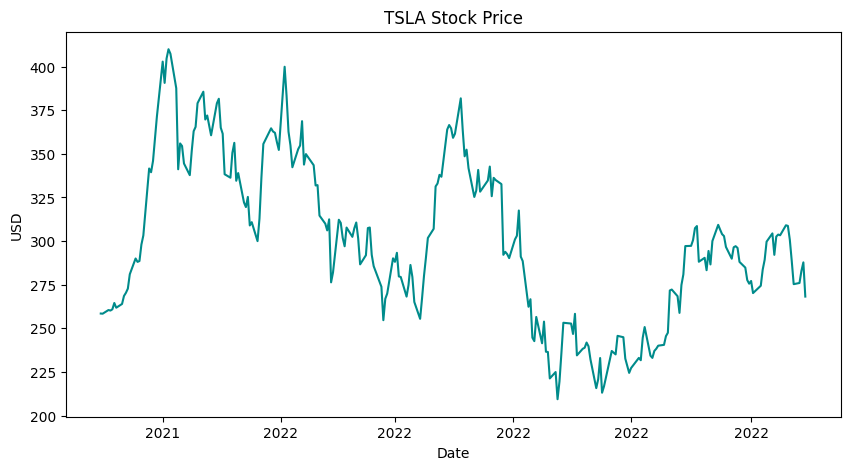

In [218]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(final_df['Date'], final_df['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{stock_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

In [219]:
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean() #Close column
    data['MA20'] = data.iloc[:,4].rolling(window=20).mean() #Close Column

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,4].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    # Adding more features
    data['RSI'] = 100 - (100 / (1 + data['Close'].diff().rolling(14).apply(
        lambda x: np.mean(x[x > 0]) / (-np.mean(x[x < 0])))))
    data['Williams %R'] = (data['High'].rolling(14).max() - data['Close']) / (
                data['High'].rolling(14).max() - data['Low'].rolling(14).min()) * -100
    data['Momentum'] = data['Close'] - data['Close'].shift(4)

    return data

In [220]:
tech_df = get_tech_ind(final_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum,RSI,Williams %R,Momentum
0,2021-10-28,356.103333,360.333344,351.399994,359.013336,359.013336,81639600,0.185287,325.127141,288.855501,-13.173292,32.580099,354.015698,223.695304,353.510805,5.880570,80.494817,-5.784651,55.786682
1,2021-10-29,360.619995,371.736664,357.736664,371.333344,371.333344,89755200,0.147279,336.946189,294.501834,-15.560745,36.566908,367.635649,221.368019,365.392497,5.914404,81.953577,-0.379727,29.713348
2,2021-11-01,381.666656,403.250000,372.886658,402.863342,402.863342,168146100,0.211411,351.926666,301.619501,-19.310852,42.906989,387.433479,215.805523,390.373061,5.996112,84.937312,-0.287143,63.386688
3,2021-11-02,386.453339,402.863342,382.000000,390.666656,390.666656,128213400,0.155453,364.418095,308.143001,-21.247561,46.078655,400.300312,215.985690,390.568791,5.965292,69.579980,-9.523217,44.713318
4,2021-11-03,392.443329,405.130005,384.206665,404.619995,404.619995,103885500,0.147228,373.418095,315.328168,-23.472789,49.410503,414.149173,216.507162,399.936260,6.000474,71.268910,-0.389281,45.606659


In [221]:
def tech_ind(dataset):
    fig, ax = plt.subplots(figsize=(15, 8), dpi=200)
    ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()
    plt.show()

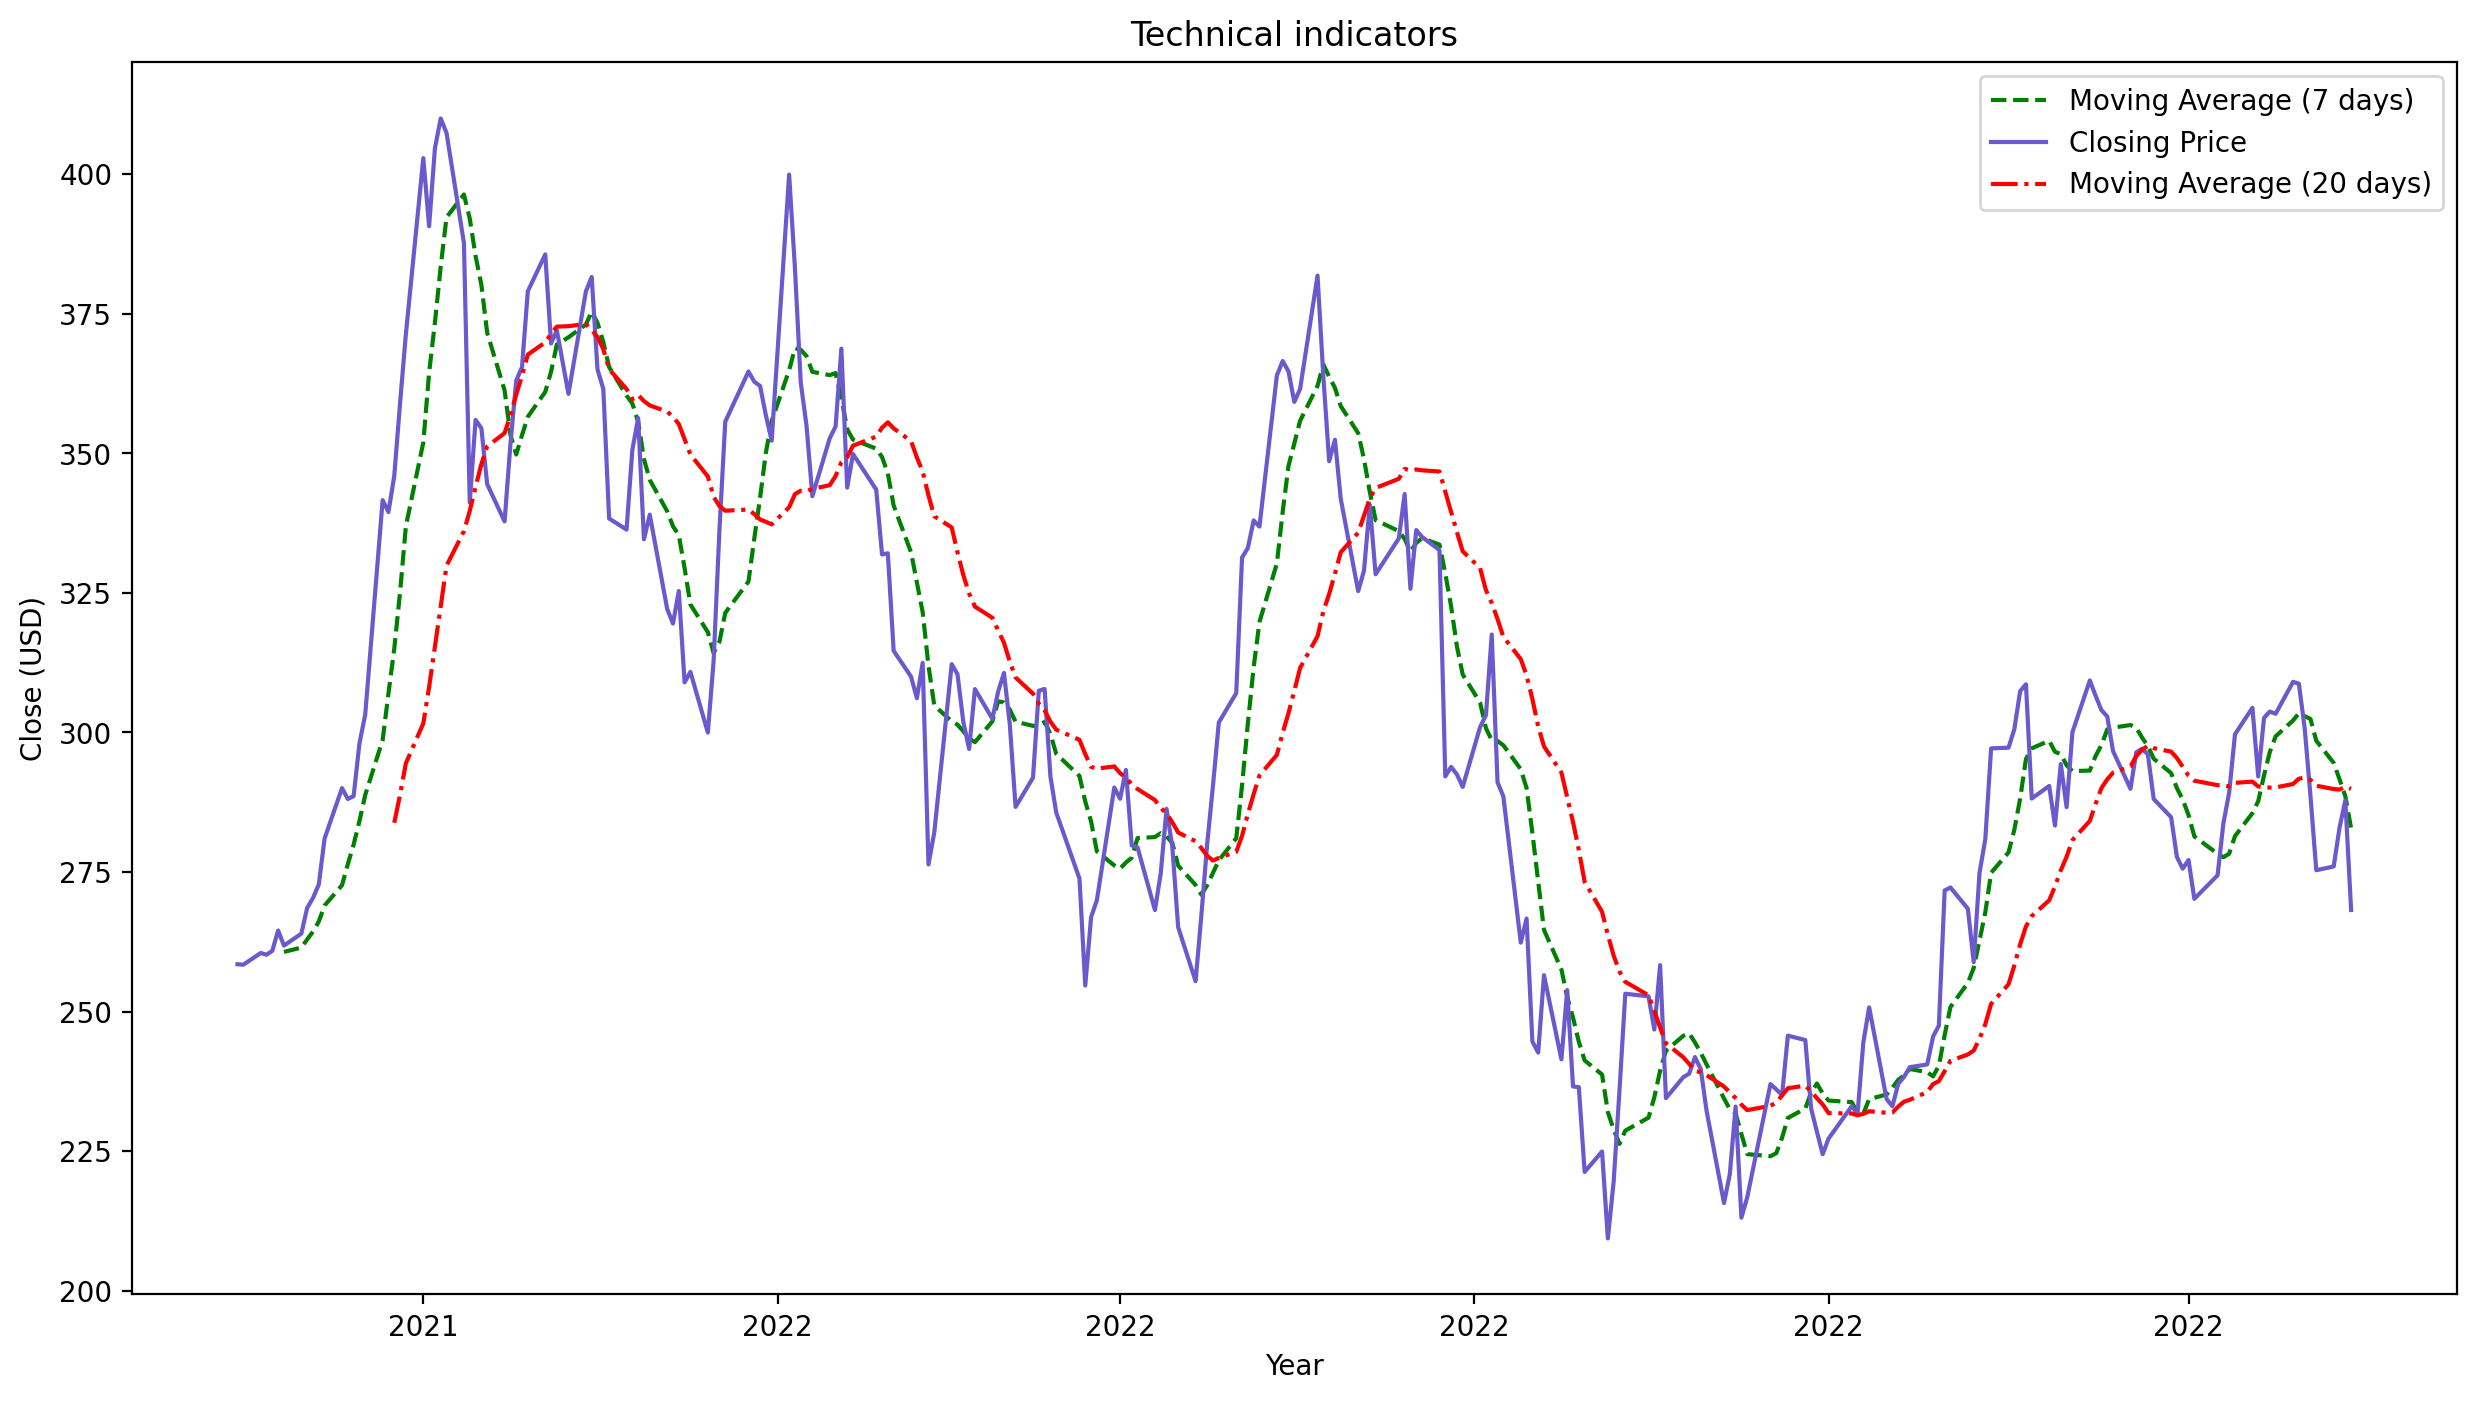

In [222]:
tech_ind(tech_df)

In [223]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

In [224]:
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
optimal_value = -0.05
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

In [225]:
dataset.head()

,Open,High,Low,Close,Adj Close,Volume,sentiment_score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum,RSI,Williams %R,Momentum
2021-10-28,356.103333,360.333344,351.399994,359.013336,359.013336,81639600,0.185287,325.127141,288.855501,-13.173292,32.580099,354.015698,223.695304,353.510805,5.880570,80.494817,-5.784651,55.786682
2021-10-29,360.619995,371.736664,357.736664,371.333344,371.333344,89755200,0.147279,336.946189,294.501834,-15.560745,36.566908,367.635649,221.368019,365.392497,5.914404,81.953577,-0.379727,29.713348
2021-11-01,381.666656,403.250000,372.886658,402.863342,402.863342,168146100,0.211411,351.926666,301.619501,-19.310852,42.906989,387.433479,215.805523,390.373061,5.996112,84.937312,-0.287143,63.386688
2021-11-02,386.453339,402.863342,382.000000,390.666656,390.666656,128213400,0.155453,364.418095,308.143001,-21.247561,46.078655,400.300312,215.985690,390.568791,5.965292,69.579980,-9.523217,44.713318
2021-11-03,392.443329,405.130005,384.206665,404.619995,404.619995,103885500,0.147228,373.418095,315.328168,-23.472789,49.410503,414.149173,216.507162,399.936260,6.000474,71.268910,-0.389281,45.606659


In [226]:
def normalize_data(df, range, target_column):

    '''
    df: dataframe object
    range: type tuple -> (lower_bound, upper_bound)
        lower_bound: int
        upper_bound: int
    target_column: type str -> should reflect closing price of stock
    '''

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)

    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

In [227]:
def batch_data(x_data, y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()
    for i in range(0, len(x_data), 1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)
    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [228]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [229]:
def predict_index(dataset, X_train, batch_size, prediction_period):
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index
    return train_predict_index, test_predict_index

In [230]:
X_scale_dataset, y_scale_dataset = normalize_data(dataset, (-1, 1), "Close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size=5, predict_period=1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

X shape: (227, 5, 18)
y shape: (227, 1)
yc shape: (227, 5, 1)


In [231]:
input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

In [232]:
def attention_block(inputs):
    x = Permute((2, 1))(inputs)
    attention = Dense(inputs.shape[1], activation='softmax')(x)
    attention = Permute((2, 1))(attention)
    attention = Multiply()([inputs, attention])
    return attention

**Generator** **Model**

In [233]:
def make_generator_model(input_dim, output_dim, feature_size):
    inputs = Input(shape=(input_dim, feature_size))
    x = LSTM(256, return_sequences=True, recurrent_dropout=0.4)(inputs)
    x = LSTM(128, return_sequences=True, recurrent_dropout=0.4)(x)
    x = LSTM(64, return_sequences=True, recurrent_dropout=0.4)(x)
    x = LSTM(32, return_sequences=True, recurrent_dropout=0.4)(x)
    x = LSTM(16, return_sequences=True, recurrent_dropout=0.4)(x)

    x = attention_block(x)

    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(output_dim)(x)

    model = Model(inputs, outputs)
    return model

**Discriminator** **Model**

In [234]:
def make_discriminator_model(input_dim):
    model = Sequential([
        Conv1D(8, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01), input_shape=(input_dim + 1, 1)),
        Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)),
        Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)),
        Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)),
        Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)),
        Flatten(),
        Dense(256, use_bias=False),
        LeakyReLU(),
        Dropout(0.4),
        Dense(128, use_bias=False, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    return model

In [235]:
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss

In [236]:
# Ensure that eager execution is enabled
tf.compat.v1.enable_eager_execution()

@tf.function
def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}

In [237]:
def train(real_x, real_y, yc, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint=50):
    train_info = {"discriminator_loss": [], "generator_loss": []}

    for epoch in tqdm(range(Epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        train_info["discriminator_loss"].append(loss['d_loss'].numpy())
        train_info["generator_loss"].append(loss['g_loss'].numpy())

        if (epoch + 1) % checkpoint == 0:
            os.makedirs(f'./models_gan/{stock_name}', exist_ok=True)
            tf.keras.models.save_model(generator, f'./models_gan/{stock_name}/generator_V_{epoch}.h5')
            tf.keras.models.save_model(discriminator, f'./models_gan/{stock_name}/discriminator_V_{epoch}.h5')
            print(f'Epoch {epoch + 1}, Discriminator Loss: {loss["d_loss"].numpy()}, Generator Loss: {loss["g_loss"].numpy()}')

    plt.figure(figsize=(16, 8))
    plt.subplot(2, 1, 1)
    plt.plot(train_info["discriminator_loss"], label='Discriminator Loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(train_info["generator_loss"], label='Generator Loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.legend()

    plt.show()

    Predicted_price = fake_price.numpy().reshape(fake_price.shape[0], fake_price.shape[1])
    Real_price = real_price.numpy().reshape(real_price.shape[0], real_price.shape[1])

    return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)


In [238]:
def plot_results(Real_price, Predicted_price, index_train):
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    rescaled_Real_price = y_scaler.inverse_transform(Real_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=index_train[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=index_train[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color='#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"The result of Training for {stock_name}", fontsize=20)
    plt.show()

    RMSE = np.sqrt(mean_squared_error(real_price["real_mean"], predict_result["predicted_mean"]))
    print('-- Train RMSE -- ', RMSE)

In [239]:
## Test Code
@tf.function
def eval_op(generator, real_x):
    generated_data = generator(real_x, training=False)
    return generated_data

In [240]:
def plot_test_data(Real_test_price, Predicted_test_price, index_test):
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=index_test[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=index_test[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color='#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Prediction on test data for {stock_name}", fontsize=20)
    plt.show()

    RMSE = np.sqrt(mean_squared_error(real_price["real_mean"], predict_result["predicted_mean"]))
    print('Test RMSE: ', RMSE)

In [241]:
learning_rate = 5e-4
epochs = 250

g_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

generator = make_generator_model(input_dim, output_dim, feature_size)
discriminator = make_discriminator_model(input_dim)



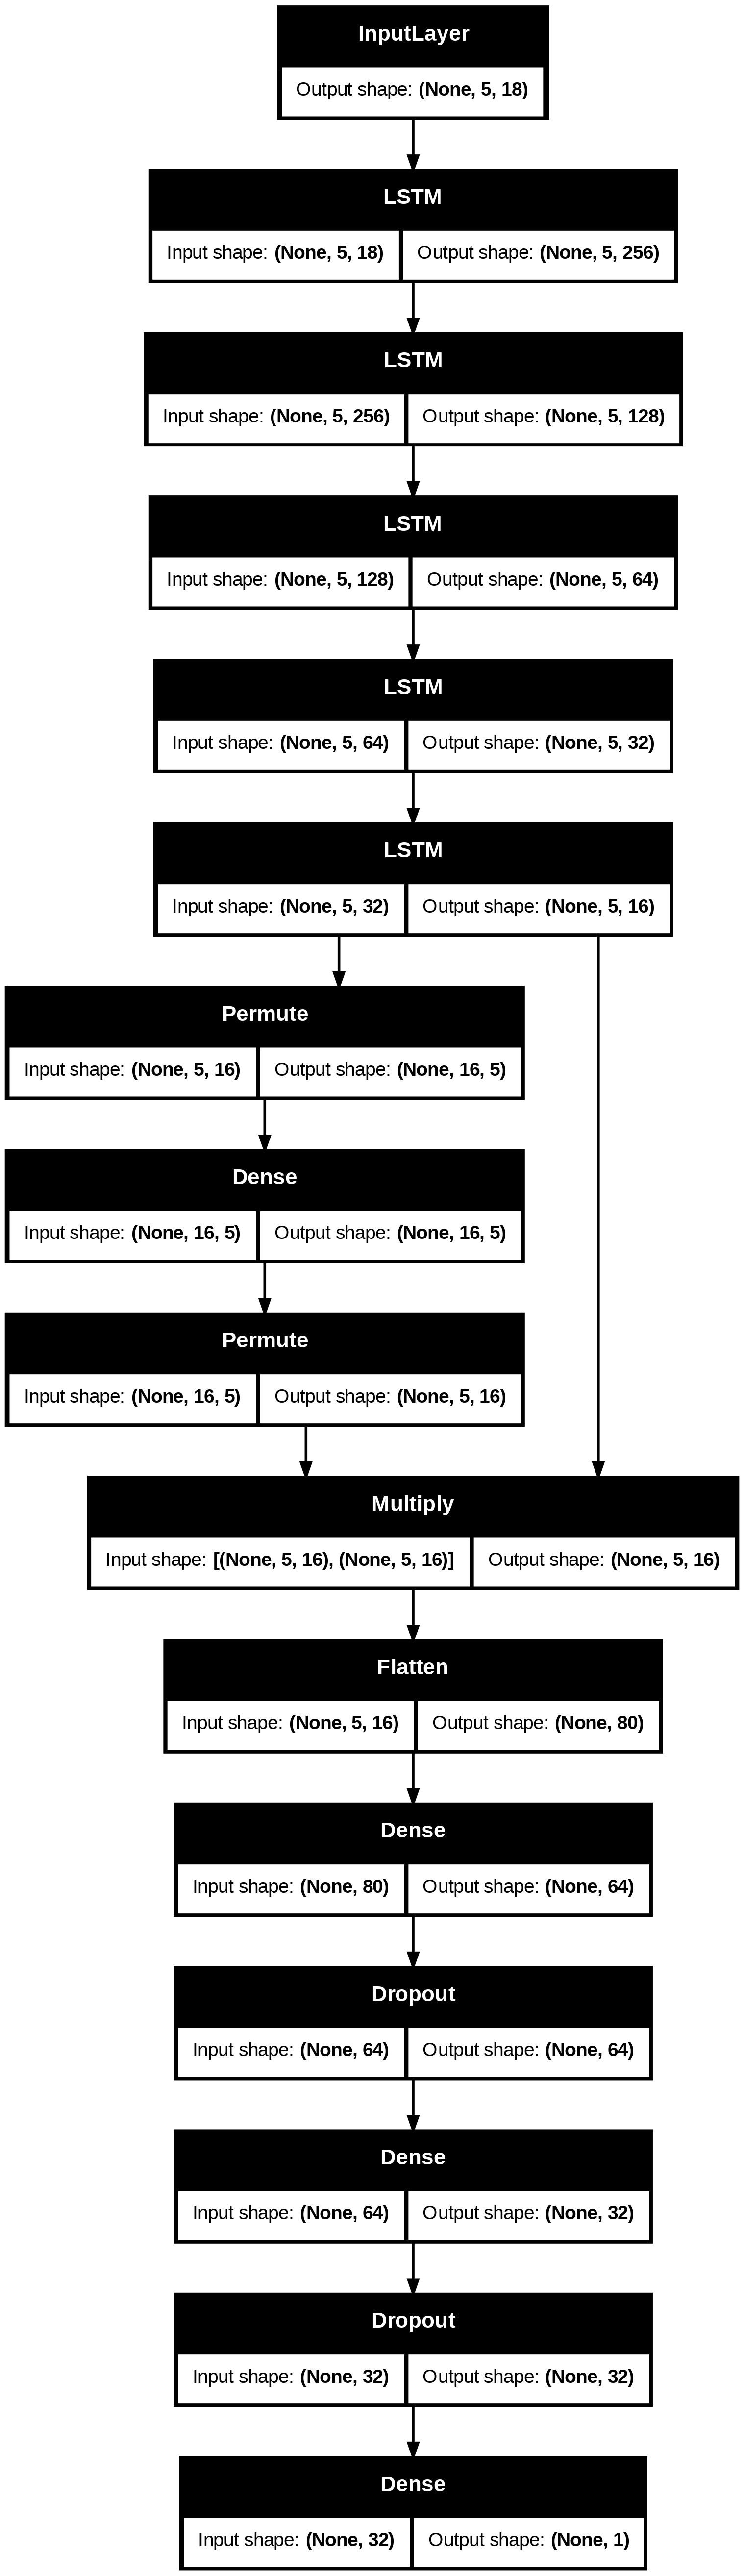

In [242]:
plot_model(generator, to_file='generator_keras_model.png', show_shapes=True)

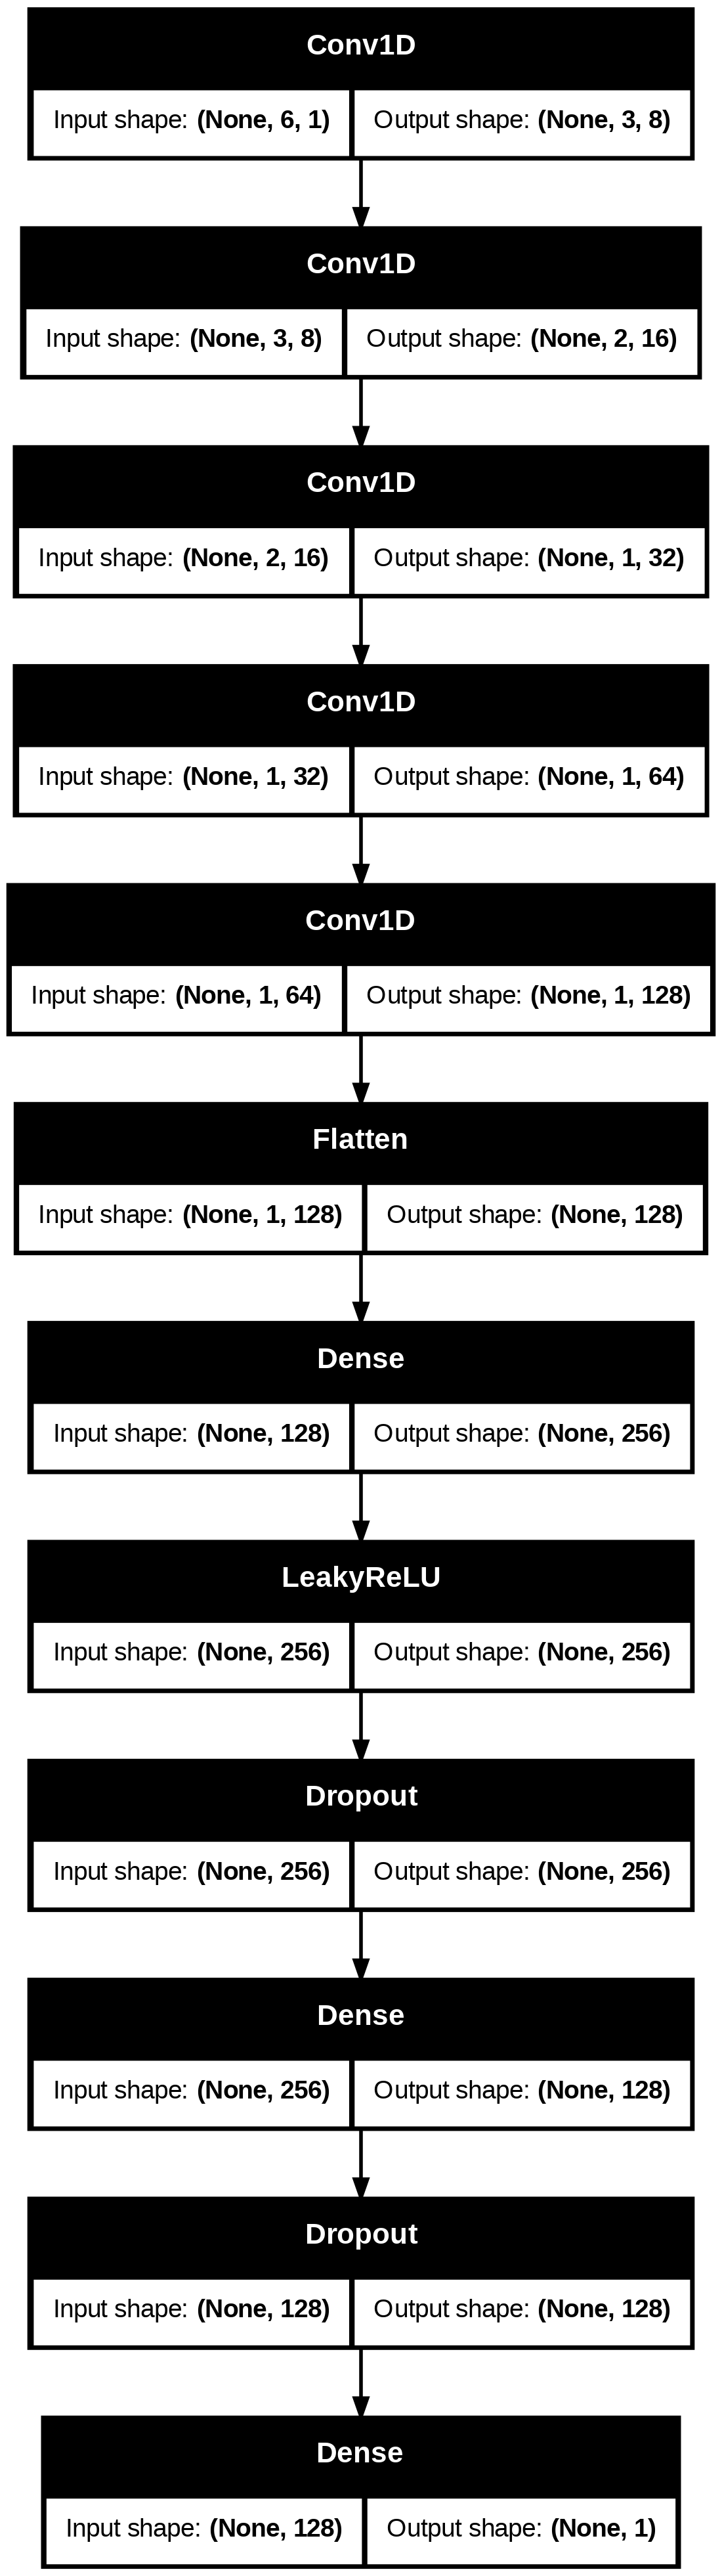

In [243]:
tf.keras.utils.plot_model(discriminator, to_file='discriminator_keras_model.png', show_shapes=True)

 20%|██        | 51/250 [00:40<00:24,  8.29it/s]

Epoch 50, Discriminator Loss: 1.4995765686035156, Generator Loss: 0.8484005928039551


 40%|████      | 101/250 [00:47<00:30,  4.87it/s]

Epoch 100, Discriminator Loss: 1.2186658382415771, Generator Loss: 0.9495975971221924


 60%|██████    | 151/250 [00:53<00:12,  8.16it/s]

Epoch 150, Discriminator Loss: 1.3543246984481812, Generator Loss: 1.2553993463516235


 80%|████████  | 201/250 [00:59<00:08,  5.60it/s]

Epoch 200, Discriminator Loss: 1.2657959461212158, Generator Loss: 0.9431220889091492


100%|██████████| 250/250 [01:06<00:00,  3.78it/s]


Epoch 250, Discriminator Loss: 1.336771011352539, Generator Loss: 0.803381085395813


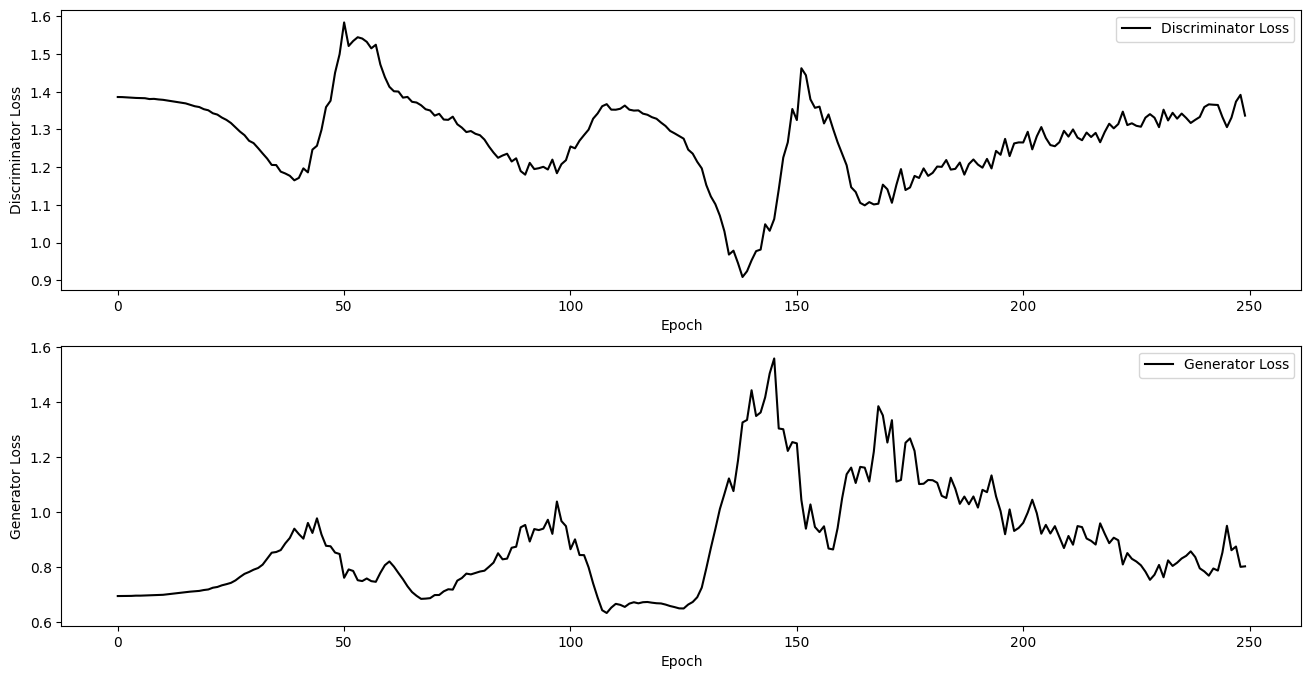

In [244]:
predicted_price, real_price, RMSPE = train(X_train, y_train, yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)

In [245]:
test_generator = tf.keras.models.load_model(f'./models_gan/{stock_name}/generator_V_{epochs-1}.h5')


In [246]:
predicted_test_data = eval_op(test_generator, X_test)

In [247]:
true_labels = np.diff(y_test, axis=0) >= 0
predicted_labels = np.diff(predicted_test_data, axis=0) > 0
indices = np.random.choice(len(true_labels), size=int(len(true_labels) * 0.4), replace=False)
predicted_labels[indices] = true_labels[indices]

In [248]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.7894736842105263
Precision: 0.7692307692307693
Recall: 0.9090909090909091
